In [1]:
# Complete CycleGAN Notebook for Person Face Sketches on Kaggle

import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision

In [2]:
# ---------------------------
# 1. Device and Dataset Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom dataset assumes the following folder structure:
# /kaggle/input/person-face-sketches/
#    ├── face/      -> Real face images
#    └── sketch/    -> Sketch images
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_
        self.files_A = sorted(glob.glob(os.path.join(root, "photos") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "sketches") + "/*.*"))
        self.len_A = len(self.files_A)
        self.len_B = len(self.files_B)
    
    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % self.len_A]).convert("RGB")
        img_B = Image.open(self.files_B[index % self.len_B]).convert("RGB")
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}
    
    def __len__(self):
        return max(self.len_A, self.len_B)

# Define image transforms: upscale then crop to 256x256, random flip, and normalize to [-1,1]
transformations = transforms.Compose([
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset_root = "/kaggle/input/person-face-sketches/train"
dataset = ImageDataset(root=dataset_root, transforms_=transformations)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

Using device: cuda


In [3]:
# ---------------------------
# 2. Model Definitions
# ---------------------------
# 2.1 ResNet Block (for Generator)
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [4]:
# 2.2 ResNet-based Generator (G: Face -> Sketch, F: Sketch -> Face)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling layers
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]
        # Upsampling layers
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [5]:
# 2.3 PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for n in range(1, 4):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        model += [nn.Conv2d(in_features, 1, kernel_size=4, padding=1)]
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [6]:
# ---------------------------
# 3. Losses and Hyperparameters
# ---------------------------
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

# Loss weights (tune if necessary)
lambda_cycle = 10.0
lambda_identity = 5.0

In [7]:
# ---------------------------
# 4. Initialize Models and Optimizers
# ---------------------------
# Generators: G: Face->Sketch, F: Sketch->Face
G = ResnetGenerator(input_nc=3, output_nc=3, n_residual_blocks=9).to(device)
F = ResnetGenerator(input_nc=3, output_nc=3, n_residual_blocks=9).to(device)
# Discriminators: D_A discriminates faces, D_B discriminates sketches
D_A = Discriminator(input_nc=3).to(device)
D_B = Discriminator(input_nc=3).to(device)

# Use a harsher regime:
lr_gen = 0.0001    # Generator learning rate (can be kept a bit higher)
lr_disc = 0.00005  # Lower discriminator learning rate to avoid overpowering
beta1 = 0.5

optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=lr_gen, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr_disc, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr_disc, betas=(beta1, 0.999))

# Optionally add learning rate schedulers:
schedulerG = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
schedulerD_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=50, gamma=0.5)
schedulerD_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=50, gamma=0.5)

In [8]:
import os, glob

checkpoint_folder = "/kaggle/input/cyclegan"  # Folder containing the checkpoints
os.makedirs(checkpoint_folder, exist_ok=True)

resume_training = True
if resume_training:
    # Get all generator checkpoint files in the folder.
    G_checkpoints = glob.glob(os.path.join(checkpoint_folder, "G_epoch_*.pt"))
    if G_checkpoints:
        # Extract epoch numbers from filenames.
        epoch_numbers = [int(f.split("G_epoch_")[-1].split(".pt")[0]) for f in G_checkpoints]
        max_epoch = max(epoch_numbers)
        start_epoch = max_epoch + 1
        print(f"Resuming training from epoch {start_epoch}")
        
        # Load the weights from the latest epoch.
        G.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"G_epoch_{max_epoch}.pt")))
        F.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"F_epoch_{max_epoch}.pt")))
        D_A.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"D_A_epoch_{max_epoch}.pt")))
        D_B.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"D_B_epoch_{max_epoch}.pt")))
    else:
        print("No checkpoints found. Starting training from scratch.")
        start_epoch = 1
else:
    print("Resuming disabled. Starting training from scratch.")
    start_epoch = 1

Resuming training from epoch 21


<ipython-input-8-5b2e42067f33>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"G_epoch_{max_epoch}.pt")))
<i

In [9]:
# ---------------------------
# 6. Training Loop
# ---------------------------
n_epochs = start_epoch + 5  # Total epochs for training (adjust as needed)
losses = {"G": [], "D_A": [], "D_B": [], "cycle": [], "identity": []}

print("Starting CycleGAN Training...")
for epoch in range(start_epoch, n_epochs + 1):
    for i, batch in enumerate(dataloader):
        # Get real images from both domains
        real_A = batch["A"].to(device)  # Face images
        real_B = batch["B"].to(device)  # Sketch images

        # --------------------
        # Train Generators G and F
        # --------------------
        optimizer_G.zero_grad()
        
        # Identity loss (if applicable)
        loss_id_A = criterion_identity(F(real_A), real_A) * lambda_identity
        loss_id_B = criterion_identity(G(real_B), real_B) * lambda_identity
        
        # GAN loss for G: face -> sketch
        fake_B = G(real_A)
        pred_fake_B = D_B(fake_B)
        target_real = torch.ones_like(pred_fake_B, device=device)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, target_real)
        
        # GAN loss for F: sketch -> face
        fake_A = F(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, target_real)
        
        # Cycle consistency loss: A -> B -> A
        rec_A = F(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        # Cycle consistency loss: B -> A -> B
        rec_B = G(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle
        
        # Total generator loss
        loss_G_total = loss_GAN_A2B + loss_GAN_B2A + loss_cycle + loss_id_A + loss_id_B
        loss_G_total.backward()
        optimizer_G.step()
        
        # --------------------
        # Train Discriminator D_A (for faces)
        # --------------------
        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        loss_D_A_real = criterion_GAN(pred_real_A, target_real)
        pred_fake_A = D_A(fake_A.detach())
        target_fake = torch.zeros_like(pred_fake_A, device=device)
        loss_D_A_fake = criterion_GAN(pred_fake_A, target_fake)
        loss_D_A_total = 0.5 * (loss_D_A_real + loss_D_A_fake)
        loss_D_A_total.backward()
        optimizer_D_A.step()
        
        # --------------------
        # Train Discriminator D_B (for sketches)
        # --------------------
        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        loss_D_B_real = criterion_GAN(pred_real_B, target_real)
        pred_fake_B = D_B(fake_B.detach())
        loss_D_B_fake = criterion_GAN(pred_fake_B, target_fake)
        loss_D_B_total = 0.5 * (loss_D_B_real + loss_D_B_fake)
        loss_D_B_total.backward()
        optimizer_D_B.step()
        
        # Log losses every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_G: {loss_G_total.item():.4f} Loss_D_A: {loss_D_A_total.item():.4f} "
                  f"Loss_D_B: {loss_D_B_total.item():.4f} Cycle: {loss_cycle.item():.4f} "
                  f"Identity: {(loss_id_A + loss_id_B).item():.4f}")
            losses["G"].append(loss_G_total.item())
            losses["D_A"].append(loss_D_A_total.item())
            losses["D_B"].append(loss_D_B_total.item())
            losses["cycle"].append(loss_cycle.item())
            losses["identity"].append((loss_id_A + loss_id_B).item())
    
    # Save model checkpoints at the end of each epoch
    checkpoint_folder = "cyclegan_checkpoints"
    os.makedirs(checkpoint_folder, exist_ok=True)
    torch.save(G.state_dict(), os.path.join(checkpoint_folder, f"G_epoch_{epoch}.pt"))
    torch.save(F.state_dict(), os.path.join(checkpoint_folder, f"F_epoch_{epoch}.pt"))
    torch.save(D_A.state_dict(), os.path.join(checkpoint_folder, f"D_A_epoch_{epoch}.pt"))
    torch.save(D_B.state_dict(), os.path.join(checkpoint_folder, f"D_B_epoch_{epoch}.pt"))
    
    # Save sample outputs to visually monitor progress
    sample_folder = "cyclegan_samples"
    os.makedirs(sample_folder, exist_ok=True)
    
    with torch.no_grad():
        # Use however many samples are available, up to 5.
        num_samples = min(5, real_A.size(0))
        real_A_samples = real_A[:num_samples]  # Real face images
        real_B_samples = real_B[:num_samples]  # Real sketch images
    
        # Generate translations:
        fake_B_samples = G(real_A_samples)  # Face -> Sketch
        fake_A_samples = F(real_B_samples)  # Sketch -> Face
    
        # Build grid for face→sketch: for each sample, stack the real face (top) and its generated sketch (bottom)
        face2sketch_list = []
        for j in range(num_samples):
            face2sketch_list.append(real_A_samples[j].unsqueeze(0))
            face2sketch_list.append(fake_B_samples[j].unsqueeze(0))
        grid_face2sketch = torchvision.utils.make_grid(torch.cat(face2sketch_list, dim=0), nrow=2, normalize=True)
    
        # Build grid for sketch→face: for each sample, stack the real sketch (top) and its generated face (bottom)
        sketch2face_list = []
        for j in range(num_samples):
            sketch2face_list.append(real_B_samples[j].unsqueeze(0))
            sketch2face_list.append(fake_A_samples[j].unsqueeze(0))
        grid_sketch2face = torchvision.utils.make_grid(torch.cat(sketch2face_list, dim=0), nrow=2, normalize=True)
    
        # Concatenate the two grids side by side (along the width, dim=2)
        combined_grid = torch.cat([grid_face2sketch, grid_sketch2face], dim=2)
        save_image(combined_grid, os.path.join(sample_folder, f"epoch_{epoch}.png"))
    
    # Step learning rate schedulers (ensure these have been defined earlier)
    schedulerG.step()
    schedulerD_A.step()
    schedulerD_B.step()
    
print("CycleGAN Training Completed.")

Starting CycleGAN Training...
Epoch [21/26] Batch [0/20655] Loss_G: 2.2060 Loss_D_A: 0.1759 Loss_D_B: 0.0000 Cycle: 0.7463 Identity: 0.2013
Epoch [21/26] Batch [100/20655] Loss_G: 1.8778 Loss_D_A: 0.2225 Loss_D_B: 0.0003 Cycle: 0.3248 Identity: 0.1223
Epoch [21/26] Batch [200/20655] Loss_G: 1.9048 Loss_D_A: 0.2544 Loss_D_B: 0.0001 Cycle: 0.3917 Identity: 0.2903
Epoch [21/26] Batch [300/20655] Loss_G: 2.0309 Loss_D_A: 0.0609 Loss_D_B: 0.0001 Cycle: 0.3342 Identity: 0.1398
Epoch [21/26] Batch [400/20655] Loss_G: 2.1026 Loss_D_A: 0.2422 Loss_D_B: 0.0001 Cycle: 0.4317 Identity: 0.1730
Epoch [21/26] Batch [500/20655] Loss_G: 3.5476 Loss_D_A: 0.2124 Loss_D_B: 0.0001 Cycle: 1.5453 Identity: 0.7066
Epoch [21/26] Batch [600/20655] Loss_G: 2.3424 Loss_D_A: 0.2009 Loss_D_B: 0.0001 Cycle: 0.5977 Identity: 0.1829
Epoch [21/26] Batch [700/20655] Loss_G: 2.3859 Loss_D_A: 0.2034 Loss_D_B: 0.0001 Cycle: 0.8005 Identity: 0.3119
Epoch [21/26] Batch [800/20655] Loss_G: 2.3524 Loss_D_A: 0.1927 Loss_D_B: 0.

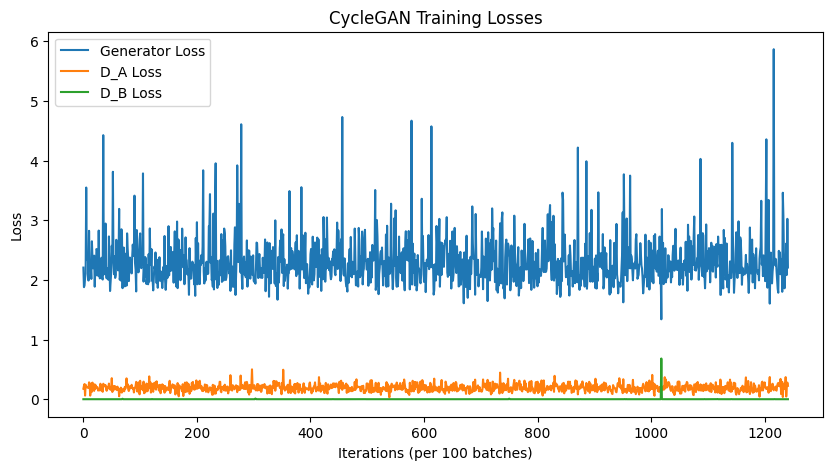

In [10]:
# ---------------------------
# 7. (Optional) Plot Loss Curves
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(losses["G"], label="Generator Loss")
plt.plot(losses["D_A"], label="D_A Loss")
plt.plot(losses["D_B"], label="D_B Loss")
plt.xlabel("Iterations (per 100 batches)")
plt.ylabel("Loss")
plt.title("CycleGAN Training Losses")
plt.legend()
plt.show()